In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO USE THE FEATURE ENGINEERING
# df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']

# # Create 'total_charges' feature
# df['total_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

# # Create 'total_minutes' feature
# df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
# df = df.drop(['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1)

# # Delete contributing features for 'total_charges'
# df = df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

# # Delete contributing features for 'total_minutes'
# df = df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes'], axis=1)


# df.drop(['state', 'area_code', 'account_length'], axis=1, inplace=True)


###################

###ONE HOT ENCODING
df = pd.get_dummies(df, columns=['area_code','state'])


### MOVING THE Y VARIABLE TO THE END
churn = df['churn']
df = df.drop('churn', axis=1)
df['churn'] = churn


data=np.array(df)


data[data=='no']=0
data[data=='yes']=1
data[data==False]=0
data[data==True]=1
print(data[0])
X=data[:,:-1]
y=data[:,-1]



### SPLITTING THE DATA INTO TRAIN, VALIDATION AND TEST SETS

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

###DATA NORMALIZATION
def normalize(X):
    X = X.astype(float)
    X=(X-X.mean(axis=0))/X.std(axis=0)
    return X
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

#SMOTE, oversampling the minority class (will read more about this later)
X_train_oversampled_smote = []
labels_train_oversampled_smote = []
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])
for _ in range(X_train.shape[0]):
    p = np.random.random()
    #sample from majority class
    if p < 0.5:
        X_train_oversampled_smote.append(X_train[np.random.choice(indices_0)])
        labels_train_oversampled_smote.append(0)
    #sample from minority class
    else:
        #get two random samples from minority class
        minority_samp_1 = X_train[np.random.choice(indices_1)]
        minority_samp_2 = X_train[np.random.choice(indices_1)]
        
        #get random proportion with which to mix them
        prop = np.random.random()
        
        #generate synthetic sample from minority class
        synthetic_minority_samp = prop*minority_samp_1 + (1-prop)*minority_samp_2
        X_train_oversampled_smote.append(synthetic_minority_samp)
        labels_train_oversampled_smote.append(1)
        
X_train = np.array(X_train_oversampled_smote)
y_train = np.array(labels_train_oversampled_smote)

print(y_train[y_train==0].shape)
print(X_train.shape)

####################


[107 0 1 26 161.6 123 27.47 195.5 103 16.62 254.4 103 11.45 13.7 3 3.7 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(1514,)
(2975, 71)


In [5]:
### LOGISTIC REGRESSION IMPLEMENTATION

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(X,W,b):
    A=np.dot(X,W)+b
    A=A.astype(float)
    return sigmoid(A)


### CROSS ENTROPY LOSS FUNCTION, USE TO EVALUATE THE MODEL
def loss(y,y_hat):
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))


### GRADIENT DESCENT IMPLEMENTATION, USE TO TRAIN THE MODEL

def gradient_descent(X,y,W,b,learning_rate,epochs,regularization_term):
    costs=[]
    for epoch in range(epochs):
        
        y_hat = forward(X,W,b)
        l=loss(y,y_hat)
        print(f"Epoch: {epoch}, Loss: {l}")
        costs.append(l)
    
        Z=y_hat-y
        dW = (np.dot(X.T, Z) + regularization_term * W)/X.shape[0]
        db=np.mean(Z)
        dW=dW.astype(float)
        W=W-learning_rate*dW
        b=b-learning_rate*db
        
    return W,b,costs



def fit_logistic(X, y, lr, epochs, reg):
    W,b=np.random.randn(X.shape[1]),np.random.randn(1)
    W_fit,b_fit,costs  = gradient_descent(X, y, W, b, lr, epochs, reg)
    return W_fit, b_fit, costs


### PREDICTION AND ACCURACY FUNCTIONS

def predict(X,W,b,threshold=0.5):
    y_hat=forward(X,W,b)
    y_hat[y_hat>=threshold]=1
    y_hat[y_hat<threshold]=0
    return y_hat

def accuracy(y,y_hat):
    return np.sum(y==y_hat)/y.shape[0]
    

In [6]:
### HYPERPARAMETER TUNING

lr_value=[0.01,0.05,0.1,0.5,1,2,10]
reg_value=[0.01,0.05,0.1,0.5,1,2,10]
epochs=[1000,5000,10000,20000]
max_accuracy=0
default_epoch=10000
default_lr=0.05
default_reg=0.05

default_threshold=0.1
with open('output.txt', 'w') as f:
    pass

for lr in lr_value:
###FITTING THE MODEL
   W, b, costs = fit_logistic(X_train, y_train, lr, default_epoch, default_reg)
### USING W and b to predict the validation set
   y_hat = predict(X_val, W, b, threshold=default_threshold)
### CALCULATING THE ACCURACY, if the accuracy improved, we save the variables
   if accuracy(y_val,y_hat)>max_accuracy:
            W_best_fit=W
            b_best_fit=b
            costs_best_fit=costs
            max_accuracy=accuracy(y_val,y_hat)
            
            
### WRITING THE RESULTS IN A FILE to keep track of the training process
   with open('output.txt', 'a') as f:
        f.write(f"Training with epoch={default_epoch}, lr={lr}, reg={default_reg}\n")
        f.write("-------------------------------------------------\n")
        f.write('\n')
        f.write(f"Validation Loss: {loss(y_val,forward(X_val,W,b))}\n")
        f.write(f"Validation Accuracy: {accuracy(y_val,y_hat)}\n")
        y_test_hat=predict(X_test,W,b,threshold=default_threshold)
        f.write("Test loss:{}\n".format(loss(y_test,forward(X_test,W,b))))
        f.write("Test accuracy:{}\n".format(accuracy(y_test,y_test_hat)))
        f.write("-------------------------------------------------\n")
        f.write("\n")
        f.close()


### REPEATING THE SAME PROCESS FOR REGULARIZATION AND EPOCHS

for reg in reg_value:
   W, b, costs = fit_logistic(X_train, y_train, default_lr, default_epoch, reg)
   y_hat = predict(X_val, W, b,threshold=default_threshold)
   if accuracy(y_val,y_hat)>max_accuracy:
            W_best_fit=W
            b_best_fit=b
            costs_best_fit=costs
            max_accuracy=accuracy(y_val,y_hat)
            
            
   with open('output.txt', 'a') as f: 
        f.write(f"Training with epoch={default_epoch}, lr={default_lr}, reg={reg}\n")
        f.write("-------------------------------------------------\n")
        f.write('\n')
        f.write(f"Validation Loss: {loss(y_val,forward(X_val,W,b))}\n")
        f.write(f"Validation Accuracy: {accuracy(y_val,y_hat)}\n")
        y_test_hat=predict(X_test,W,b,threshold=default_threshold)
        f.write("Test loss:{}\n".format(loss(y_test,forward(X_test,W,b))))
        f.write("Test accuracy:{}\n".format(accuracy(y_test,y_test_hat)))
        f.write("-------------------------------------------------\n")
        f.write("\n")
        f.close()


for epoch in epochs:
        
   W, b, costs = fit_logistic(X_train, y_train, default_lr, epoch, default_reg)
   
   y_hat = predict(X_val, W, b,threshold=default_threshold)
   
   if accuracy(y_val,y_hat)>max_accuracy:
            W_best_fit=W
            b_best_fit=b
            costs_best_fit=costs
            max_accuracy=accuracy(y_val,y_hat)
            
            
   with open('output.txt', 'a') as f:
        f.write(f"Training with epoch={epoch}, lr={default_lr}, reg={default_reg}\n")
        f.write("-------------------------------------------------\n")
        f.write('\n')
        f.write(f"Validation Loss: {loss(y_val,forward(X_val,W,b))}\n")
        f.write(f"Validation Accuracy: {accuracy(y_val,y_hat)}\n")
        y_test_hat=predict(X_test,W,b,threshold=default_threshold)
        f.write("Test loss:{}\n".format(loss(y_test,forward(X_test,W,b))))
        f.write("Test accuracy:{}\n".format(accuracy(y_test,y_test_hat)))
        f.write("-------------------------------------------------\n")
        f.write("\n")
        f.close()
        
### SAVING THE BEST FIT VARIABLES
np.savez('weights.npz', W=W_best_fit, b=b_best_fit,costs=costs_best_fit,lr=default_lr,reg=default_reg,epoch=default_epoch)




    
 


Epoch: 0, Loss: 3.037808677571248
Epoch: 1, Loss: 3.0348371755165027
Epoch: 2, Loss: 3.031869298571236
Epoch: 3, Loss: 3.028905040645509
Epoch: 4, Loss: 3.0259443989891257
Epoch: 5, Loss: 3.0229873811484227
Epoch: 6, Loss: 3.0200339809203505
Epoch: 7, Loss: 3.017084199374681
Epoch: 8, Loss: 3.0141380321737716
Epoch: 9, Loss: 3.011195480108641
Epoch: 10, Loss: 3.0082565450165917
Epoch: 11, Loss: 3.005321228448478
Epoch: 12, Loss: 3.002389515835728
Epoch: 13, Loss: 2.9994614198439096
Epoch: 14, Loss: 2.996536931442237
Epoch: 15, Loss: 2.9936160591507184
Epoch: 16, Loss: 2.990698784875834
Epoch: 17, Loss: 2.9877851232570634
Epoch: 18, Loss: 2.9848750660300976
Epoch: 19, Loss: 2.9819686128564307
Epoch: 20, Loss: 2.9790657621273597
Epoch: 21, Loss: 2.976166518925911
Epoch: 22, Loss: 2.973270870540884
Epoch: 23, Loss: 2.9703788268884175
Epoch: 24, Loss: 2.967490375605791
Epoch: 25, Loss: 2.96460552809413
Epoch: 26, Loss: 2.9617242752650323
Epoch: 27, Loss: 2.9588466114966456
Epoch: 28, Loss:

/tmp/ipykernel_41108/3873510658.py:14: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))


Epoch: 369, Loss: 0.9074234505922454
Epoch: 370, Loss: 0.9059840439361184
Epoch: 371, Loss: 0.9045524467963595
Epoch: 372, Loss: 0.9031277157022759
Epoch: 373, Loss: 0.9017106002179207
Epoch: 374, Loss: 0.9003010413831727
Epoch: 375, Loss: 0.8988982020204126
Epoch: 376, Loss: 0.8975021256304028
Epoch: 377, Loss: 0.8961134531919477
Epoch: 378, Loss: 0.8947321184269131
Epoch: 379, Loss: 0.8933573996548618
Epoch: 380, Loss: 0.8919892758288744
Epoch: 381, Loss: 0.8906283247926309
Epoch: 382, Loss: 0.8892745712089585
Epoch: 383, Loss: 0.8879266875002342
Epoch: 384, Loss: 0.8865863993286581
Epoch: 385, Loss: 0.8852520125414581
Epoch: 386, Loss: 0.8839245113342797
Epoch: 387, Loss: 0.8826039393759156
Epoch: 388, Loss: 0.8812891882428016
Epoch: 389, Loss: 0.8799811899355531
Epoch: 390, Loss: 0.8786794781606102
Epoch: 391, Loss: 0.8773844370106822
Epoch: 392, Loss: 0.8760956034774252
Epoch: 393, Loss: 0.8748128767429738
Epoch: 394, Loss: 0.8735362740471275
Epoch: 395, Loss: 0.8722657919911184
E

Threshold: 0.1, F1 Score: 0.35879218472468916
Threshold: 0.2, F1 Score: 0.40625
Threshold: 0.30000000000000004, F1 Score: 0.47214854111405835
Threshold: 0.4, F1 Score: 0.5077399380804953
Threshold: 0.5, F1 Score: 0.5428571428571428
Threshold: 0.6, F1 Score: 0.5690376569037657
Threshold: 0.7000000000000001, F1 Score: 0.5754716981132076
Threshold: 0.8, F1 Score: 0.5517241379310345
Threshold: 0.9, F1 Score: 0.3496503496503496


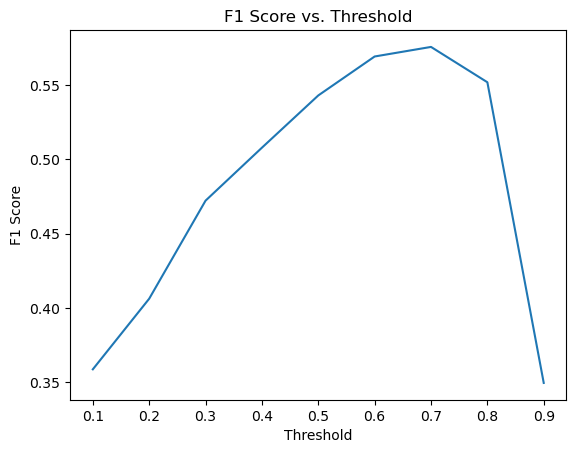

In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
import numpy as np
# Define thresholds
thresholds = np.arange(0.1, 1.0, 0.1)


weights=np.load('weights.npz')
W=weights['W']
b=weights['b']

# Predict on test set
y_pred = predict(X_test, W, b, threshold=default_threshold)

y_pred=y_pred.astype(int)
y_test=y_test.astype(int)
# Initialize list to store F1 scores
f1_scores = []
best_threshold=0
best_f1=0
# Loop over thresholds
for threshold in thresholds:
    # Predict on test set
    y_pred = predict(X_test, W, b, threshold=threshold)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    if f1>best_f1:
        best_threshold=threshold
        best_f1=f1
    # Append F1 score to list
    f1_scores.append(f1)

# Print F1 scores
for threshold, f1 in zip(thresholds, f1_scores):
    print(f'Threshold: {threshold}, F1 Score: {f1}')
    
# Plot F1 scores
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()


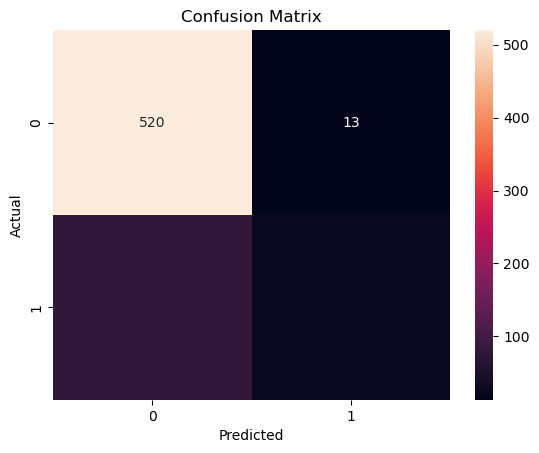

Test accuracy: 0.85423197492163
0.7000000000000001
Stored 'best_threshold' (float64)


In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"Test accuracy: {accuracy(y_test, y_pred)}")
print(best_threshold)

%store best_threshold
